# Yield curve

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [36]:
data = pd.read_csv('bonds.csv', index_col=False)
data.head()

,bond,isin,issue_date,maturity_date,date,close_price
0,CAN 0.25 Mar 26,CA135087L518,10/9/2020,3/1/2026,1/5/2026,99.70
1,CAN 0.25 Mar 26,CA135087L518,10/9/2020,3/1/2026,1/6/2026,99.71
2,CAN 0.25 Mar 26,CA135087L518,10/9/2020,3/1/2026,1/7/2026,99.71
3,CAN 0.25 Mar 26,CA135087L518,10/9/2020,3/1/2026,1/8/2026,99.72
4,CAN 0.25 Mar 26,CA135087L518,10/9/2020,3/1/2026,1/9/2026,99.73


In [37]:
# For YTM calculation, we need numerical methods (here we use bisection). This is a helper function to compute YTM.
def ytm(PV, cashflows, times):
    """
    PV        : float
    cashflows : array-like, CF_i
    times     : array-like, t_i (floats allowed)
    """
    cashflows = np.asarray(cashflows, dtype=float)
    times = np.asarray(times, dtype=float)
    def f(y):
        return np.sum(cashflows / ((1 + y)**times)) - PV
    
    a, b = -0.99, 1.00
    fa, fb = f(a), f(b)

    # Bisection requires a sign change on [a, b]
    if not np.isfinite(fa) or not np.isfinite(fb):
        raise ValueError("f(low) or f(high) is not finite; adjust bounds or inputs.")
    if fa == 0.0:
        return a
    if fb == 0.0:
        return b
    if fa * fb > 0:
        raise ValueError(
            f"Bisection requires f(low) and f(high) to have opposite signs. "
            f"Got f({a})={fa:.6g}, f({b})={fb:.6g}. Try widening bounds."
        )

    for _ in range(200):
        m = 0.5 * (a + b)
        fm = f(m)

        # stopping conditions
        if abs(fm) <= 1e-12 or (b - a) <= 1e-12:
            return m

        # keep the sub-interval that brackets the root
        if fa * fm < 0:
            b, fb = m, fm
        else:
            a, fa = m, fm

    # If we get here, we didn't converge within max_iter
    m = 0.5 * (a + b)
    return m

In [38]:
# Helper function for accrued interest calculation
def last_coupon_date(maturity_date, date):
    """
    Returns the last March 1 or Sep 1 before maturity_date, whichever is closest to maturity_date.
    But such date should be after date.
    """
    year = maturity_date.year
    candidates = [
        pd.Timestamp(year=year,   month=3, day=1),
        pd.Timestamp(year=year,   month=9, day=1),
        pd.Timestamp(year=year-1, month=3, day=1),
        pd.Timestamp(year=year-1, month=9, day=1),
    ]
    valid = [d for d in candidates if date < d < maturity_date]
    if not valid:
        valid = [maturity_date]  # for bond maturing at Mar 2026
    return max(valid)

In [39]:
data["time"] = np.nan
data["ytm"] = np.nan
for idx, row in data.iterrows():
    coupon_rate = float(row["bond"].split()[1]) / 100
    data.at[idx, "date"] = pd.to_datetime(row["date"],format="%m/%d/%Y")
    data.at[idx, "maturity_date"] = pd.to_datetime(row["maturity_date"],format="%m/%d/%Y")
    data.at[idx, "time"] = (data.at[idx, "maturity_date"] - data.at[idx, "date"]).days / 365.0
    times = [data.at[idx, "time"]]
    # cashflows = [100 * (1 + coupon_rate / 2)]
    cashflows = [100]
    pos = data.index.get_loc(idx)
    while pos - 10 >= 0:
        pos -= 10
        if not data.at[pos, "date"] == data.at[idx, "date"]:
            raise ValueError(f"Expected date {data.at[idx, 'date']} but got {data.at[pos, 'date']}")
        times.append(data.at[pos, "time"])
        cashflows.append(100 * coupon_rate / 2)
    accrued_interest = (data.at[idx, "maturity_date"] - last_coupon_date(data.at[idx, "maturity_date"], data.at[idx, "date"])).days / 365 * coupon_rate
    data.at[idx, "ytm"] = ytm(row["close_price"] + accrued_interest, cashflows, times)

    # print((data.at[idx, "maturity_date"] - last_coupon_date(data.at[idx, "maturity_date"], data.at[idx, "date"])).days)
    # print(times, row["close_price"], cashflows, np.sum(cashflows / ((1 + data.at[idx, "ytm"]) ** times)) - row["close_price"] - accrued_interest)

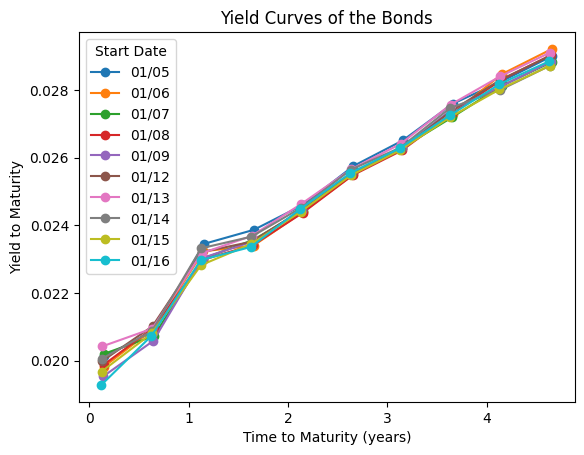

In [40]:
fig, ax = plt.subplots()
ax.set_xlabel("Time to Maturity (years)")
ax.set_ylabel("Yield to Maturity")
ax.set_title("Yield Curves of the Bonds")

start_dates = pd.date_range(start="1/5/2026",end="1/9/2026",freq="D").union(pd.date_range(start="1/12/2026",end="1/16/2026",freq="D"))
for start_date in start_dates:
    start_pos = data.index[data["date"] == start_date][0]
    start_pos = data.index.get_loc(start_pos)
    sub = data.iloc[start_pos::10]
    ax.plot(sub["time"], sub["ytm"], marker="o", label=start_date.strftime("%m/%d"))

ax.legend(title="Start Date")
plt.show()

# Spot curve

In [41]:
data["spot"] = np.nan
for idx, row in data.iterrows():
    coupon_rate = float(row["bond"].split()[1]) / 100
    # For bootstrapping. Notice that for the first bond, accumulated pmt = 0, serving as the base case.
    accumulated_pmts = 0
    pos = data.index.get_loc(idx)
    while pos - 10 >= 0:
        pos -= 10
        accumulated_pmts += coupon_rate / 2 * 100 / ((1 + data.at[pos, "spot"]) ** data.at[pos, "time"])
    accrued_interest = (data.at[idx, "maturity_date"] - last_coupon_date(data.at[idx, "maturity_date"], data.at[idx, "date"])).days / 365 * coupon_rate
    # data.at[idx, "spot"] = ((100 * (1 + coupon_rate / 2) / (row["close_price"] + accrued_interest - accumulated_pmts)) ** (1 / data.at[idx, "time"]) - 1)
    data.at[idx, "spot"] = ((100 / (row["close_price"] + accrued_interest - accumulated_pmts)) ** (1 / data.at[idx, "time"]) - 1)

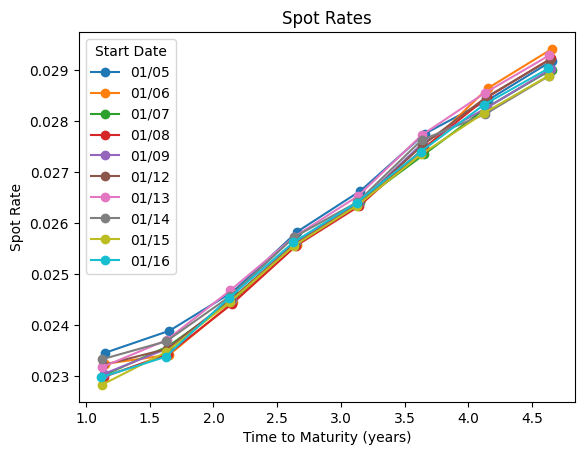

In [42]:
fig, ax = plt.subplots()
ax.set_xlabel("Time to Maturity (years)")
ax.set_ylabel("Spot Rate")
ax.set_title("Spot Rates")

start_dates = pd.date_range(start="1/5/2026",end="1/9/2026",freq="D").union(pd.date_range(start="1/12/2026",end="1/16/2026",freq="D"))
for start_date in start_dates:
    start_pos = data.index[data["date"] == start_date][0]
    start_pos = data.index.get_loc(start_pos)
    sub = data.iloc[start_pos+20::10]
    ax.plot(sub["time"], sub["spot"], marker="o", label=start_date.strftime("%m/%d"))

ax.legend(title="Start Date")
plt.show()

# Forward curve

In [43]:
data["forward"] = np.nan
for idx, row in data.iterrows():
    if idx % 20 in range(0,10):
        continue
    elif 10 <= idx < 20:
        data.at[idx, "forward"] = data.at[idx, "spot"]
        continue
    prev_spot = data.at[idx-20, "spot"]
    curr_spot = data.at[idx, "spot"]
    prev_time = data.at[idx-20, "time"]
    curr_time = data.at[idx, "time"]
    data.at[idx, "forward"] = ((1 + curr_spot) ** (curr_time) / (1 + prev_spot) ** (prev_time)) ** (1.0 / (curr_time - prev_time)) - 1

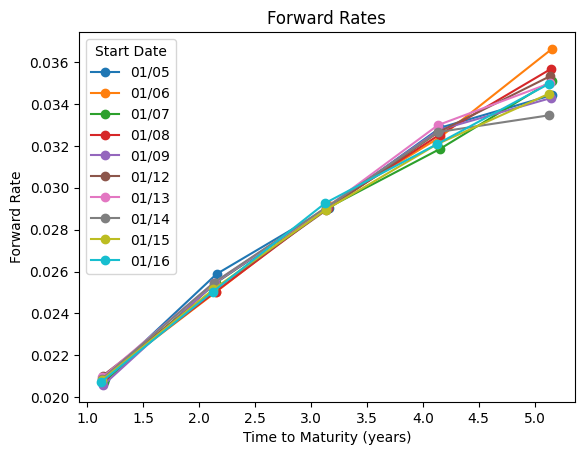

In [44]:
fig, ax = plt.subplots()
ax.set_xlabel("Time to Maturity (years)")
ax.set_ylabel("Forward Rate")
ax.set_title("Forward Rates")

start_dates = (
    pd.date_range(start="1/5/2026", end="1/9/2026", freq="D")
      .union(pd.date_range(start="1/12/2026", end="1/16/2026", freq="D"))
)

for start_date in start_dates:
    start_pos = data.index[data["date"] == start_date][0]
    start_pos = data.index.get_loc(start_pos)

    sub = data.iloc[start_pos + 10 :: 20][["time", "forward"]].copy()

    # Interpolation
    sub = sub.sort_values("time")
    sub["forward_interp"] = sub["forward"].interpolate(method="linear")
    sub = sub.dropna(subset=["forward_interp"])

    ax.plot(
        sub["time"] + 0.5,
        sub["forward_interp"],
        marker="o",
        label=start_date.strftime("%m/%d")
    )

ax.legend(title="Start Date")
plt.show()

In [45]:
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.width", None)

# data

# pd.reset_option("display.max_rows")
# pd.reset_option("display.max_columns")
# pd.reset_option("display.width")

# Log returns and covariance matrices

In [46]:
data["log_ytm"] = np.nan
for idx, row in data.iterrows():
    if idx % 20 in range(10,19):
        data.at[idx, "log_ytm"] = np.log(data.at[idx+1, "ytm"] / row["ytm"])

data["log_forward"] = np.nan
for idx, row in data.iterrows():
    if idx % 20 in range(10,19):
        data.at[idx, "log_forward"] = np.log(data.at[idx+1, "forward"] / row["forward"])

In [47]:
log_ytm_matrix = np.column_stack([
    data["log_ytm"].iloc[10:19].values,
    data["log_ytm"].iloc[30:39].values,
    data["log_ytm"].iloc[50:59].values,
    data["log_ytm"].iloc[70:79].values,
    data["log_ytm"].iloc[90:99].values,
])
log_forward_matrix = np.column_stack([
    data["log_forward"].iloc[10:19].values,
    data["log_forward"].iloc[30:39].values,
    data["log_forward"].iloc[50:59].values,
    data["log_forward"].iloc[70:79].values,
    data["log_forward"].iloc[90:99].values,
])

In [48]:
cov_ytm = np.cov(log_ytm_matrix, rowvar=False)
cov_forward = np.cov(log_forward_matrix, rowvar=False)

In [49]:
# I'm writing this code to let it print out matrix so that I can directly copy-paste to LaTeX.
def to_latex_bmatrix(M, fmt="{:.6f}"):
    lines = []
    for row in M:
        line = " & ".join(fmt.format(x) for x in row)
        lines.append(line)
    body = " \\\\\n".join(lines)
    return "\\begin{bmatrix}\n" + body + "\n\\end{bmatrix}"

print(to_latex_bmatrix(cov_ytm))
print(to_latex_bmatrix(cov_forward))

\begin{bmatrix}
0.000139 & -0.000040 & -0.000025 & -0.000009 & 0.000066 \\
-0.000040 & 0.000075 & 0.000040 & 0.000037 & -0.000038 \\
-0.000025 & 0.000040 & 0.000026 & 0.000025 & -0.000016 \\
-0.000009 & 0.000037 & 0.000025 & 0.000040 & 0.000004 \\
0.000066 & -0.000038 & -0.000016 & 0.000004 & 0.000072
\end{bmatrix}
\begin{bmatrix}
0.000139 & -0.000139 & -0.000007 & 0.000029 & 0.000294 \\
-0.000139 & 0.000290 & -0.000008 & 0.000028 & -0.000575 \\
-0.000007 & -0.000008 & 0.000023 & 0.000018 & 0.000032 \\
0.000029 & 0.000028 & 0.000018 & 0.000184 & -0.000034 \\
0.000294 & -0.000575 & 0.000032 & -0.000034 & 0.001446
\end{bmatrix}


In [50]:
def to_latex_vector(v, fmt="{:.6f}"):
    body = " \\\\\n".join(fmt.format(x) for x in v)
    return "\\begin{bmatrix}\n" + body + "\n\\end{bmatrix}"

def eigen(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    for i in range(len(eigenvalues)):
        print(f"% Eigenpair {i+1}")
        print(f"\\lambda_{i+1} = {eigenvalues[i]:.6e}")
        print(f"v_{i+1} = {to_latex_vector(eigenvectors[:, i])}")
        print()

print("For log_ytm:")
eigen(cov_ytm)
print("For log_forward:")
eigen(cov_forward)

For log_ytm:
% Eigenpair 1
\lambda_1 = 2.165522e-04
v_1 = \begin{bmatrix}
-0.715605 \\
0.434807 \\
0.244230 \\
0.149268 \\
-0.465750
\end{bmatrix}

% Eigenpair 2
\lambda_2 = 8.911550e-05
v_2 = \begin{bmatrix}
0.441403 \\
0.576079 \\
0.351391 \\
0.549080 \\
0.219847
\end{bmatrix}

% Eigenpair 3
\lambda_3 = 3.771261e-05
v_3 = \begin{bmatrix}
-0.525079 \\
-0.268342 \\
0.070108 \\
0.373424 \\
0.712688
\end{bmatrix}

% Eigenpair 4
\lambda_4 = 5.552961e-06
v_4 = \begin{bmatrix}
0.102749 \\
-0.484162 \\
-0.162134 \\
0.715537 \\
-0.465563
\end{bmatrix}

% Eigenpair 5
\lambda_5 = 1.632276e-06
v_5 = \begin{bmatrix}
-0.082514 \\
0.415517 \\
-0.886383 \\
0.157454 \\
0.100353
\end{bmatrix}

For log_forward:
% Eigenpair 1
\lambda_1 = 1.750717e-03
v_1 = \begin{bmatrix}
-0.197014 \\
0.375860 \\
-0.017458 \\
0.022857 \\
-0.905035
\end{bmatrix}

% Eigenpair 2
\lambda_2 = 1.959050e-04
v_2 = \begin{bmatrix}
0.267111 \\
0.066127 \\
0.086898 \\
0.957424 \\
-0.008180
\end{bmatrix}

% Eigenpair 3
\lambda_3 = 